In [1]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

Using backend: pytorch


True

### hard-coded arguments

explain GCN model

In [2]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "models/gin-virtual/checkpoint"
args.device = 0

In [3]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
# device = "cpu"
device

device(type='cuda', index=0)

In [4]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


### load model

In [5]:
import random

random.randint(0, 10)

7

In [6]:
from gnn import GNN

In [7]:
"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_val_mae', 'num_params'])

In [8]:
gnn_name = "gin-virtual"
gnn_type = "gin"
virtual_node = True

In [9]:
model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.state_dict()

model.eval()

type(model)

gnn.GNN

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=300, gamma=0.25)
reg_criterion = torch.nn.L1Loss()

### load data

In [11]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')

In [12]:
split_idx = dataset.get_idx_split()
split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([      0,       1,       2,  ..., 3045357, 3045358, 3045359]),
 tensor([3426030, 3426031, 3426032,  ..., 3803450, 3803451, 3803452]),
 tensor([3045360, 3045361, 3045362,  ..., 3426027, 3426028, 3426029]))

In [13]:
"""
get embedding
"""
model_activation = {}
def get_activation(name):
    def hook(model, input, output):
        model_activation[name] = output
    return hook

model.gnn_node.register_forward_hook(get_activation('gnn_node'))


In [14]:
"""
load training dataset
"""

name = "valid"

# 1. create train loader (don't shuffle, to maintain index order)
train_loader = DataLoader(dataset[split_idx[name]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
train_loader

In [15]:
# """
# load triplet dataset
# """
# anchor_loader = DataLoader(dataset[split_idx[name]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
# positive_loader = DataLoader(dataset[split_idx[name]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
# negative_loader = DataLoader(dataset[split_idx[name]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)


## visualise embeddings

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
# 1. create train loader (don't shuffle, to maintain index order)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [06:34<00:00,  3.77it/s]


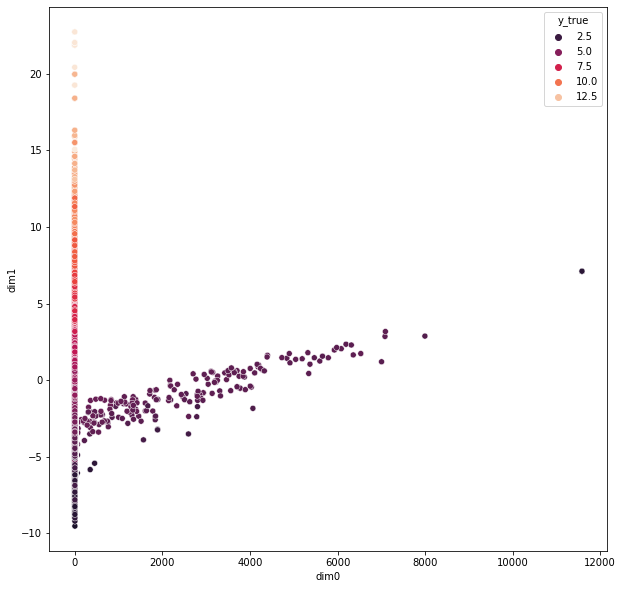

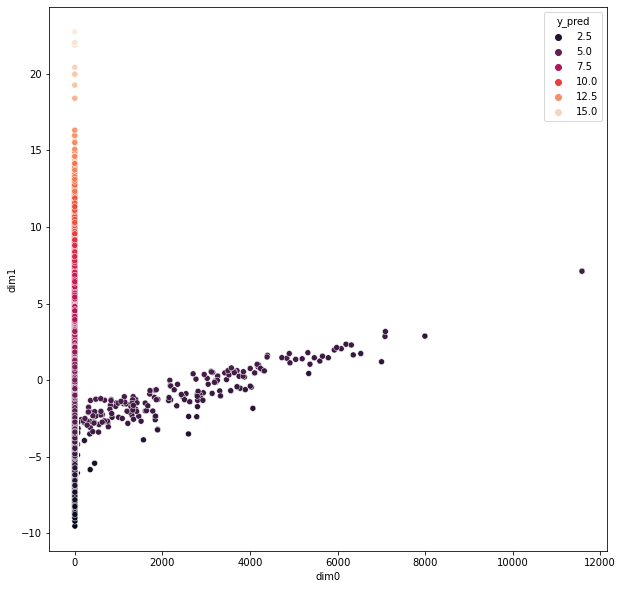

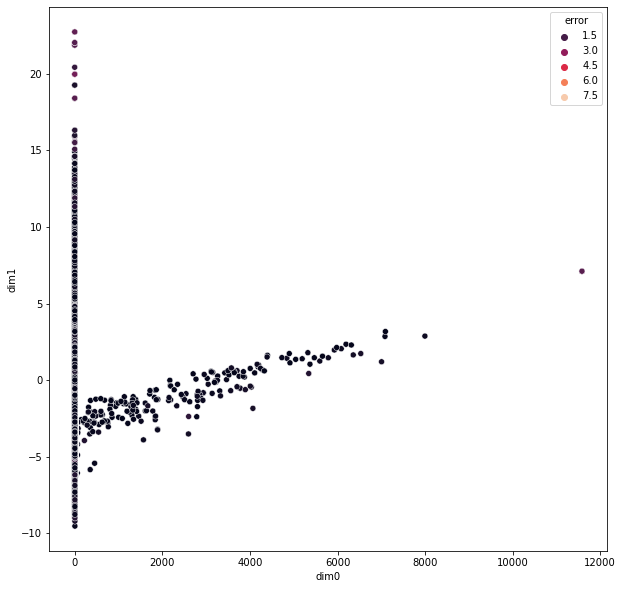

In [18]:
def getGraphEmbedding(model):
    with torch.no_grad():
        # get intermediate outputs
        h_node = model.gnn_node(batch)
        # GRAPH EMBEDDING
        h_graph = model.pool(h_node, batch.batch)
        # output
        output = model.graph_pred_linear(h_graph).view(-1)

    return h_graph, output

"""
Get intermediate graph embeddings and visualise
"""

graphEmbeddings = None
y_true = []
y_pred = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(model)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    y_pred.extend(pred_np)

    # collate graph embedding
    h_graph_np = h_graph.detach().cpu().numpy()
    if graphEmbeddings is None:
        graphEmbeddings = h_graph_np
    else:
        graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    
    
"""
pandas dataframe
"""
validDF = pd.DataFrame(zip(y_pred, y_true), columns=["y_pred", "y_true"])
validDF["error"] = (validDF["y_pred"] - validDF["y_true"]).apply(lambda x: abs(x))

"""
PCA
"""
pca = PCA()
pca.fit(graphEmbeddings)

# hardcoded = pick a smaller dimension of pca
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(graphEmbeddings)

# transform embedding
pcaEmb = pca.transform(graphEmbeddings)
# store in validDF
for i in range(n_components):
    validDF["dim{}".format(i)] = pcaEmb[:, i]
    
    
"""
plot pca
"""
plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_true", palette="rocket")
plt.show()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_pred", palette="rocket")
plt.show()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="error", palette="rocket")
plt.show()

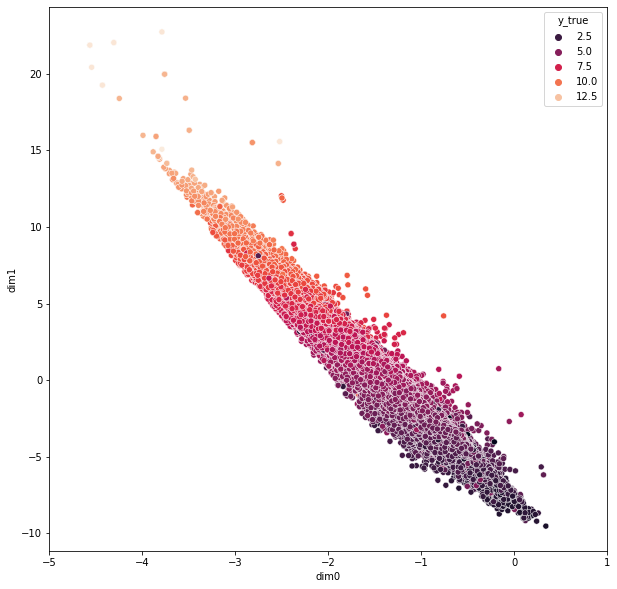

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_true", palette="rocket")
plt.xlim(-5, 1)
plt.show()

In [20]:
evaluator = PCQM4MEvaluator()

input_dict = {"y_true": torch.tensor(validDF["y_true"]), "y_pred": torch.tensor(validDF["y_pred"])}
print("GNN", evaluator.eval(input_dict)["mae"])


GNN 0.14212890543599663


### triplet loss

In [21]:
"""
define triplet loss
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn import global_add_pool

class TripletLossRegression(nn.Module):
    """
        anchor, positive, negative are node-level embeddings of a GNN before they are sent to a pooling layer,
        and hence are expected to be matrices.
        anchor_gt, positive_gt, and negative_gt are ground truth tensors that correspond to the ground-truth
        values of the anchor, positive, and negative respectively.
    """

    def __init__(self, margin: float = 0.0, eps=1e-6):
        super(TripletLossRegression, self).__init__()
        self.margin = margin
        self.eps = eps

    def forward(self, anchor_batch, negative_batch, positive_batch,
                anchor: Tensor, negative: Tensor, positive: Tensor,
                anchor_gt: Tensor, negative_gt: Tensor, positive_gt: Tensor) -> Tensor:
        anchor = global_add_pool(anchor, anchor_batch)

        positive = global_add_pool(positive, positive_batch)

        negative = global_add_pool(negative, negative_batch)

        pos_distance = torch.linalg.norm(positive - anchor, dim=1)
        negative_distance = torch.linalg.norm(negative - anchor, dim=1)

        coeff = torch.div(torch.abs(negative_gt - anchor_gt) , (torch.abs(positive_gt - anchor_gt) + self.eps))
        loss = F.relu((pos_distance - coeff * negative_distance) + self.margin)
        return torch.mean(loss)




In [22]:
"""
dynamic triplet dataset based on error
"""
# def createTripletLoader(model, train_loader, dataset, errorThres = 5) -> (anchor_loader, pos_loader, neg_loader)
def createTripletLoader(model, train_loader, dataset, errorThres = 5):

    # 2. get losses for training dataset
    y_true, y_pred = [], []
    for step, batch in enumerate(tqdm(train_loader, desc="Iteration")):
        # put batch to cuda
        batch = batch.to(device)

        # get prediction
        pred = model(batch).view(-1, )
        pred = pred.detach().cpu().tolist()
        y_pred.extend(pred)

        # get labels
        label = batch.y.detach().cpu().tolist()
        y_true.extend(label)


    # 3. convert to dataframe
    trainDF = pd.DataFrame(zip(y_pred, y_true), columns=["y_pred", "y_true"])
    trainDF["error"] = (trainDF["y_pred"] - trainDF["y_true"]).apply(lambda x: abs(x))
    # bin y_pred
    trainDF["y_class"] = trainDF["y_true"].apply(lambda x: int(np.floor(x)))

    # 4. pick data with error threshold < k
    highErrorDF = trainDF[trainDF.error > errorThres]
    lowErrorDF = trainDF[trainDF.error < errorThres]
    # create [anchorID, posId, negID]
    triplets = []
    for i, row in tqdm(list(highErrorDF.iterrows())):
        i_class = row["y_class"]

        # 4a. set i to be pos, find anchor and neg samples
        tripA = [None, None, None]
        tripA[1] = i
        # find anchor by sampling from lowErrorDF of same class
        tripA[0] = lowErrorDF[lowErrorDF.y_class == i_class].sample(1).index.item()
        # find negative by sampling from lowErrorDF of other class
        tripA[2] = lowErrorDF[lowErrorDF.y_class != i_class].sample(1).index.item()
        triplets.append(tripA)

        # 4b. set i to be neg, find anchor and pos samples
        tripB = [None, None, None]
        tripB[2] = i
        # find anchor by sampling from lowErrorDF of same class
        tripB[0] = lowErrorDF[lowErrorDF.y_class != i_class].sample(1).index.item()
        # find positive by sampling from lowErrorDF of other class
        tripB[1] = lowErrorDF[lowErrorDF.y_class != i_class].sample(1).index.item()
        triplets.append(tripB)

    # 5. create anchor, pos and neg IDs
    triplets = np.array(triplets)
    anchorIDs = list(triplets[:, 0])
    posIDs = list(triplets[:, 1])
    negIDs = list(triplets[:, 2])

    # 6. create triplet loaders
    anchor_loader = DataLoader(dataset[anchorIDs], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
    positive_loader = DataLoader(dataset[posIDs], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
    negative_loader = DataLoader(dataset[negIDs], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)

    return anchor_loader, positive_loader, negative_loader

In [25]:
model.eval()
anchor_loader, positive_loader, negative_loader = createTripletLoader(model, train_loader, dataset, errorThres=5)

model.train()
loss_accum = 0
triplet_loss_criterion = TripletLossRegression()

"""
1 epoch
"""
for step, (anchor_batch, negative_batch, positive_batch) in \
        enumerate(zip(tqdm(anchor_loader, desc="Iteration"), negative_loader, positive_loader)):
    anchor_batch = anchor_batch.to(device)
    pred_anchor = model(anchor_batch).view(-1,)
    anchor_embed = model_activation['gnn_node']

    negative_batch = negative_batch.to(device)
    pred_neg = model(negative_batch).view(-1,)
    neg_embed = model_activation['gnn_node']

    positive_batch = positive_batch.to(device)
    pred_pos= model(positive_batch).view(-1,)
    pos_embed = model_activation['gnn_node']

    optimizer.zero_grad()
    mae_loss = reg_criterion(pred_anchor, anchor_batch.y)
    tll_loss = triplet_loss_criterion(anchor_batch.batch, negative_batch.batch, positive_batch.batch, 
                                      anchor_embed, neg_embed, pos_embed,
                                      anchor_batch.y, negative_batch.y, positive_batch.y)
    loss = mae_loss + tll_loss

    if gnn_name == 'gin-virtual-bnn':
        kl_loss = model.get_kl_loss()[0]
        loss += kl_loss

    loss.backward()
    optimizer.step()

    loss_accum += loss.detach().cpu().item()


Iteration: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [06:07<00:00,  4.05it/s]


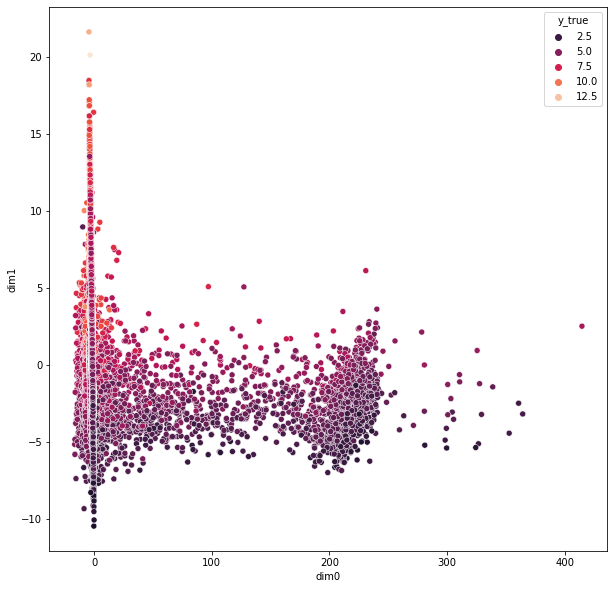

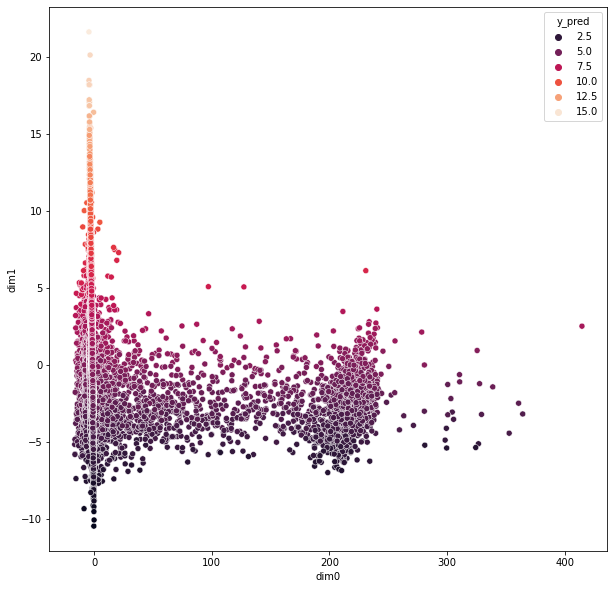

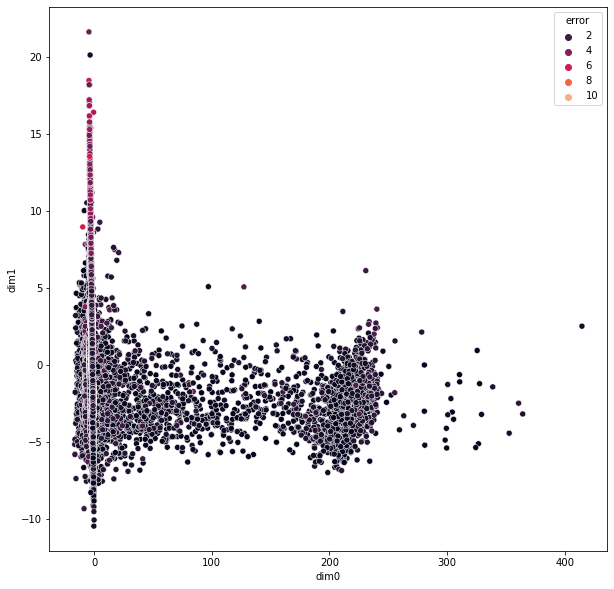

In [26]:
"""
Get intermediate graph embeddings and visualise
"""

graphEmbeddings = None
y_true = []
y_pred = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # put batch to cuda
    batch = batch.to(device)

    # get embedding
    h_graph, pred = getGraphEmbedding(model)

    # collate prediction
    pred_np = pred.detach().cpu().numpy()
    y_pred.extend(pred_np)

    # collate graph embedding
    h_graph_np = h_graph.detach().cpu().numpy()
    if graphEmbeddings is None:
        graphEmbeddings = h_graph_np
    else:
        graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)
    
    
"""
pandas dataframe
"""
validDF = pd.DataFrame(zip(y_pred, y_true), columns=["y_pred", "y_true"])
validDF["error"] = (validDF["y_pred"] - validDF["y_true"]).apply(lambda x: abs(x))

"""
PCA
"""
# hardcoded = pick a smaller dimension of pca
# n_components = 4
# pca = PCA(n_components=n_components)
# pca.fit(graphEmbeddings)

# transform embedding
pcaEmb = pca.transform(graphEmbeddings)
# store in validDF
for i in range(n_components):
    validDF["dim{}".format(i)] = pcaEmb[:, i]
    
    
"""
plot pca
"""
plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_true", palette="rocket")
plt.show()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_pred", palette="rocket")
plt.show()

plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="error", palette="rocket")
plt.show()

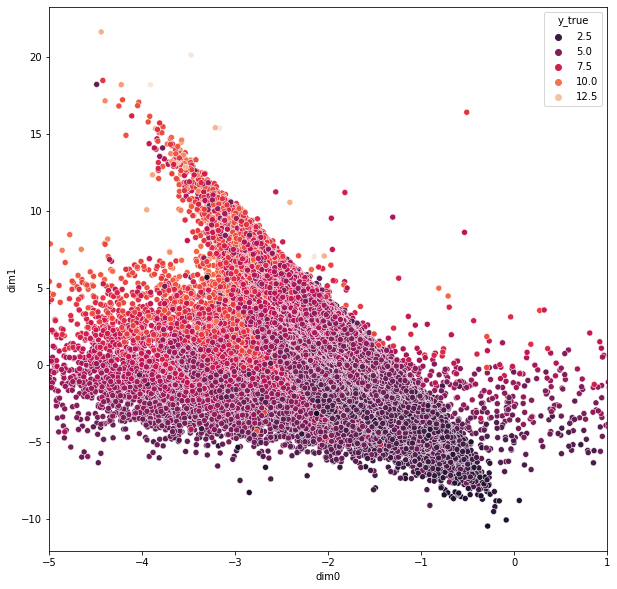

In [27]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=validDF, x="dim0", y="dim1", hue="y_true", palette="rocket")
plt.xlim(-5, 1)
plt.show()

In [28]:
evaluator = PCQM4MEvaluator()

input_dict = {"y_true": torch.tensor(validDF["y_true"]), "y_pred": torch.tensor(validDF["y_pred"])}
print("GNN", evaluator.eval(input_dict)["mae"])


GNN 0.5764280830580445
